In [47]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from scipy.optimize import leastsq,curve_fit

np.set_printoptions(threshold=np.inf)

In [48]:
def function(x, a, b, c):
    result = a * np.cosh((x-b)/a) + c
    return result

In [49]:
#读取原图片
def load_image(file_path,file_name,file_ext):
    file = file_path + file_name + file_ext;
    Image = plt.imread(file);
    [image_y_max,image_x_max] = Image.shape;
    print(f"原图片高度：{image_y_max},原图片宽度：{image_x_max}");
    plt.imshow(Image,cmap = "gray");
    plt.show()
    return Image;

In [50]:
#裁剪原图片
def extract_edge(Image,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape;
    min_x = max_x = min_y = max_y = 0;
    sum_col = np.sum(Image,axis=0);
    for i in range(0,image_x_max):
        if (sum_col[i] != 0):
            min_x = i;
            break;
    for i in range(image_x_max-1,min_x,-1):
        if (sum_col[i] != 0):
            max_x = i;
            break;


    sum_row = np.sum(Image,axis=1);
    for i in range(0,image_y_max):   
        if (sum_row[i] != 0):
            min_y = i;
            break; 
    for i in range(image_y_max - 1,min_y,-1):
        if (sum_row[i] != 0):
            max_y = i;
            break;

    Image = Image[min_y:max_y,min_x:max_x];

    [image_y_max, image_x_max] =  Image.shape;
    print('裁剪后长度:%d,裁剪后宽度:%d\n' %(image_y_max,image_x_max));

    for x in range(0,image_x_max): 
        is_white = False;
        for y in range(image_y_max-1,-1,-1):
            v = x;
            u = int(-y + image_y_max - 1);
            if (Image[u,v] != 0):
                if (is_white == False):
                    is_white = True;
                else:
                    Image[u,v] = 0;
            else:
                is_white = False;
    plt.xlim((0, image_x_max));
    plt.ylim((image_y_max, 0));
    plt.imshow(Image,cmap = "gray");
    file = file_path + file_name + "_cut.png";
    plt.savefig(file);
    plt.show();
    return Image;

In [51]:
#判断有几条曲线，选择能够提供充分样点的最大曲线数。
def get_curve_number(Image):
    [image_y_max,image_x_max] = Image.shape;
    count = np.sum(Image,axis = 0);
    num_curve = int(np.max(count));
    num_curve_part = np.where(count==num_curve);
    length = np.size(num_curve_part);

    min_length = round(image_x_max/20);

    while (length < min_length):
        count[num_curve_part] = 0;
        num_curve = int(np.max(count));
        num_curve_part= np.where(count==num_curve);
        length = np.size(num_curve_part);

    print("判定缆绳数量为：%d" %(num_curve));
    [image_y_max, image_x_max] =  Image.shape;
    print('裁剪后长度:%d,裁剪后宽度:%d\n' %(image_y_max,image_x_max));   
       
    return [num_curve,count];

In [52]:
##根据像素矩阵的列和判断是否有交点，我们希望截取一段无交点部分(最长的部分)
def get_sample_points(Image):
    [num_curve,count] = get_curve_number(Image);
    [image_y_max,image_x_max] = Image.shape;
    length = 0;
    start = end = 0;
    share_index = 0;
    while (start < image_x_max) and (end < image_x_max):
        while (start < image_x_max ) and (count[start] != num_curve):
            start = start + 1;
        end = start + 1;
        while (end < image_x_max) and (count[end] == num_curve):
            end = end + 1;
        sublength = end - start;
        if (sublength > length):
            length = sublength;
            share_index = start;
        start = end + 1;
    print('截取起点：%d, 截取长度：%d\n' %(share_index,length));
    Image_cut  = Image[ : ,share_index : share_index + length - 1];
    [imagecut_y_max,imagecut_x_max] = Image_cut.shape;
    plt.imshow(Image_cut,cmap = "gray");
    plt.show()

    sample_points = np.zeros((imagecut_x_max,2,num_curve));
    for i in range(0,imagecut_x_max):
        curve_id = 0;
        for j in range(imagecut_y_max-1,-1,-1):
            x = i + share_index;
            y = -j + imagecut_y_max - 1;
            if (Image_cut[y,i] != 0):
                sample_points[i,0,curve_id] = x;
                sample_points[i,1,curve_id] = j;
                curve_id  = curve_id + 1;
    return [Image_cut,sample_points];

In [53]:
#开始第一次拟合
def initial_fit(Image,sample_points):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(sample_points.shape[2]);
    parameter_origin = np.zeros((num_curve,3));
    for i in range(0,num_curve):
        y = sample_points[:,1,i];
        x = sample_points[:,0,i];
        parameter_initial = [image_y_max,image_x_max,-image_y_max];
        #[parameter, _] = leastsq(f_err, parameter_initial, args=(y, x));
        parameter,pcov = curve_fit(function,x,y,p0 = parameter_initial,method = 'dogbox',max_nfev=100000);
        parameter_origin[i,:] = parameter;
                                        
    plt.xlim((0, image_x_max))
    plt.ylim((image_y_max, 0))
    plt.imshow(Image,cmap = "gray");
    for id  in range(0,num_curve):
        t = parameter_origin[id,:];
        x_fit = np.zeros(image_x_max);
        y_fit = np.zeros(image_x_max);
        
        for x in range(0,image_x_max):
            x_fit[x] = x;
            y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
            
        u_fit = - y_fit + image_y_max;
        plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
    plt.show()
    return parameter_origin;
# for id in range(0,num_curve):
#     a = parameter_origin[id,0];
#     b = parameter_origin[id,1];
#     c = parameter_origin[id,2];
#     print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c));

In [54]:
def iterate_fit(Image,sample_points_origin,parameter_origin,iterate_time):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(sample_points_origin.shape[2]);

    parameter_old = parameter_origin;
    sample_points_old = sample_points_origin;

    expansion_size = int(round(image_x_max/(iterate_time)));

    for time in range(0,iterate_time):        

        pnt_num = sample_points_old.shape[0];
        x_cut_min = sample_points_old[0,0,0];
        x_cut_max = sample_points_old[pnt_num-1,0,0];
        if (x_cut_min > expansion_size):
            x_cut_min = x_cut_min - expansion_size;
        else:
            x_cut_min = 0;

        if ( image_x_max - x_cut_max > expansion_size):
            x_cut_max = x_cut_max + expansion_size;
        else:
            x_cut_max = image_x_max - 1;

        x_cut_size = int(x_cut_max - x_cut_min + 1);
        sample_points_new = np.zeros((x_cut_size,2,num_curve));
        for i in range(0,num_curve):
            for x in range(0,x_cut_size):
                sample_points_new[x,0,i] = x + x_cut_min; 

        for  x  in range(0,x_cut_size):
            for y in range(image_y_max-1,-1,-1):
                u = int(-y + image_y_max - 1);
                v = int(x + x_cut_min);
                if (Image[u,v] != 0):
                    y_distance = np.zeros(num_curve);
                    for id in range(0,num_curve):
                        t = parameter_old[id,:];
                        y_fit = t[0]*np.cosh((v - t[1])/ t[0]) + t[2];
                        y_distance[id] = np.abs(y_fit - y);

                    #寻找离这个点最近的曲线
                    min_distance = np.min(y_distance);
                    if (min_distance <= 12):
                        curve_id = np.where(y_distance == min_distance);
                        sample_points_new[x,1,curve_id] = y;

        parameter_new = np.zeros((num_curve,3));
        for id in range(0, num_curve):
            sample_x = sample_points_new[:,0,id];
            sample_y = sample_points_new[:,1,id];
            #将曲线中没有选定点的列删除。
            zero_column = np.where(sample_y == 0);
            sample_x = np.delete(sample_x,zero_column);
            sample_y = np.delete(sample_y,zero_column);


            parameter_initial = parameter_old[id,:]; 
            #[parameter, _] = leastsq(f_err, parameter_initial, args=(sample_y, sample_x));      
            parameter,pcov = curve_fit(function,sample_x,sample_y,p0 = parameter_initial,method = 'dogbox',max_nfev=100000);
            parameter_new[id,:] = parameter;             

        print("Iterate_time:%d \n" %(time));
        for id in range(0,num_curve):
            a = parameter_new[id,0];
            b = parameter_new[id,1];
            c = parameter_new[id,2];
            print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c))   
        parameter_old = parameter_new;
        sample_points_old = sample_points_new;
    return [parameter_old,sample_points_old];

In [55]:
def calculate_radian(parameter,sample_points,file_name):
    num_curve = int(sample_points.shape[2]);
    radian = np.zeros(num_curve);
    for id in range(0,num_curve):
        sample_x = sample_points[:,0,id];
        sample_y = sample_points[:,1,id];
        #将曲线中没有选定点的列删除。
        zero_column = np.where(sample_y == 0);
        sample_x = np.delete(sample_x,zero_column);
        sample_y = np.delete(sample_y,zero_column);
                
        #取出样本点的起点和终点，画出直线。
        pnt_num = sample_x.shape[0];
        x_start = sample_x[0];
        y_start = sample_y[0];
        x_end = sample_x[pnt_num-1];
        y_end = sample_y[pnt_num-1];
                
        #起点到终点的直线。
        k = (y_end - y_start) / (x_end - x_start);
        b = y_end - k * x_end;
                

                
        #计算曲线到直线的距离，取出最大值计算弯曲度
        line_length  = np.sqrt(pow(x_end - x_start,2) + pow(y_end - y_start,2));
        distance = np.zeros(pnt_num);
        for i in range(0,pnt_num):
            distance[i] = np.abs(k*sample_x[i] - sample_y[i] + b) / np.sqrt(1 + k*k);

        max_distance = np.max(distance);
        radian[id] = max_distance / line_length;
        print("y = %f x + %f \n" %(k,b));
    print(radian)
    file = ".\\parameter\\" + file_name +"_parameter.txt";
    f = open(file, 'w',encoding='UTF-8');
    f.write("%12s %12s %12s\n" %("a","b","c"));
    for i in range(0,num_curve):
        f.write(str(parameter[i,:])+'\n')
    f.write("radian : "+ str(radian));
    f.close();

    return radian

In [56]:
def save_png(Image,parameter,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(parameter.shape[0]);
    plt.xlim((0, image_x_max));
    plt.ylim((image_y_max, 0));
    plt.imshow(Image,cmap = "gray");
    for id  in  range(0,num_curve):
        t = parameter[id,:];
        x_fit = np.zeros(image_x_max);
        y_fit = np.zeros(image_x_max);
        for x in range(0,image_x_max):
            x_fit[x] = x;
            y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
        u_fit = - y_fit + image_y_max - 1;
        plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
    file = file_path + file_name + "_fit.png";
    plt.savefig(file);
    plt.show()

In [57]:
def catenary_fit(file_path,file_name,file_ext,iterate_time):
    Image = load_image(file_path,file_name,file_ext);
    Image = extract_edge(Image,file_path,file_name);
    [Image_cut,sample_points_origin] = get_sample_points(Image);
    parameter_origin = initial_fit(Image,sample_points_origin);
    [parameter,sample_points] = iterate_fit(Image,sample_points_origin,parameter_origin,iterate_time);
    radian = calculate_radian(parameter,sample_points,file_name);
    save_png(Image,parameter,file_path,file_name);


.\figure\1.png

迭代次数: 6
原图片高度：1440,原图片宽度：2560


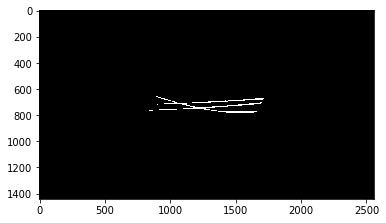

裁剪后长度:129,裁剪后宽度:876



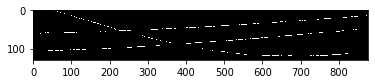

判定缆绳数量为：3
裁剪后长度:129,裁剪后宽度:876

截取起点：431, 截取长度：396



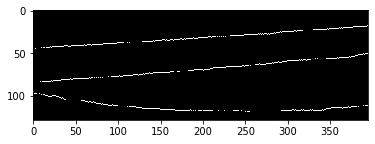

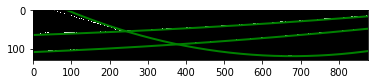

Iterate_time:0 

y = 19024.699831*cosh((x- -618.600554)/19024.699831) + -18969.650690 

y = 17388.800651*cosh((x- -802.760951)/17388.800651) + -17388.742790 

y = 1495.983095*cosh((x- 679.536520)/1495.983095) + -1486.372255 

Iterate_time:1 

y = 16348.220066*cosh((x- -444.778937)/16348.220066) + -16287.632259 

y = 15679.744312*cosh((x- -665.613235)/15679.744312) + -15674.262697 

y = 1599.691774*cosh((x- 686.262831)/1599.691774) + -1589.824560 

Iterate_time:2 

y = 14809.093761*cosh((x- -351.218886)/14809.093761) + -14745.789630 

y = 12862.172481*cosh((x- -448.349870)/12862.172481) + -12848.569342 

y = 1728.342821*cosh((x- 698.178592)/1728.342821) + -1718.304947 

Iterate_time:3 

y = 14809.130152*cosh((x- -351.228740)/14809.130152) + -14745.826623 

y = 12854.123650*cosh((x- -447.815238)/12854.123650) + -12840.505525 

y = 1728.272610*cosh((x- 698.131457)/1728.272610) + -1718.233865 

Iterate_time:4 

y = 14809.130152*cosh((x- -351.228740)/14809.130152) + -14745.826623 

y = 1285

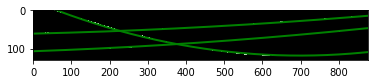

In [58]:
file_path = ".\\figure\\"
file_name = [str(f) for f in range(1,2)];
file_ext = ".png";
iterate_time = 6;
for f in file_name:
    print(file_path + f + file_ext + "\n");
    print("迭代次数: %d" %(iterate_time));
    catenary_fit(file_path,f,file_ext,iterate_time);